<a href="https://colab.research.google.com/github/momenashra/LLMs_learning/blob/main/Multimodal_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from urllib.request import urlopen
from PIL import Image
# Load an AI-generated image of a puppy playing in the snow
puppy_path = "https://media.istockphoto.com/id/636039508/photo/nine-week-old-golden-retriever-puppy-running-in-the-snow.jpg?s=612x612&w=0&k=20&c=JMgRDqkHBQ747VX6IrhTY0KLJliQGb1Wu8n_kdxvHoQ="
image = Image.open(urlopen(puppy_path)).convert("RGB")
caption = "a puppy playing in the snow"

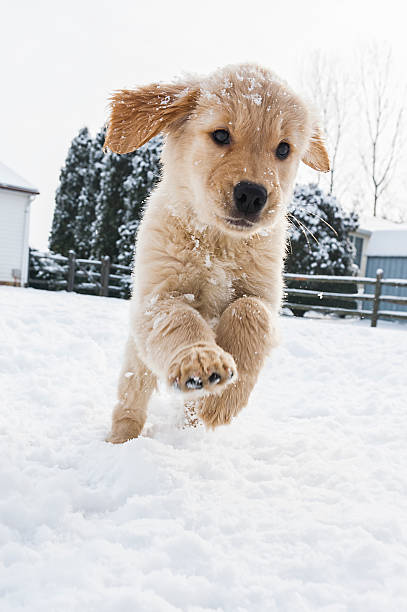

In [2]:
image

In [3]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
model_id = "openai/clip-vit-base-patch32"

In [4]:
# Load a tokenizer to preprocess the text
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
# Load a processor to preprocess the images
clip_processor = CLIPProcessor.from_pretrained(model_id)
# Main model for generating text and image embeddings
model = CLIPModel.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [5]:
# Tokenize our input
inputs = clip_tokenizer(caption, return_tensors="pt")

In [6]:
inputs["input_ids"][0]

tensor([49406,   320,  6829,  1629,   530,   518,  2583, 49407])

In [7]:
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [8]:
# Create a text embedding
text_embedding = model.get_text_features(**inputs) #model.get_text_features(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
text_embedding.shape

torch.Size([1, 512])

In [9]:
# Preprocess image
processed_image = clip_processor(text=None, images=image, return_tensors="pt" )["pixel_values"]
processed_image.shape

torch.Size([1, 3, 224, 224])

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

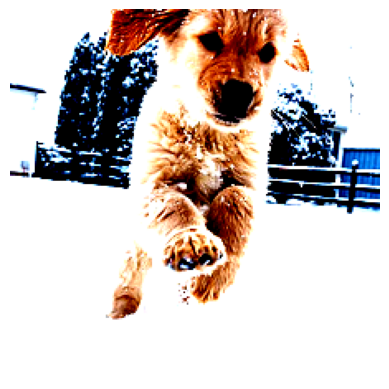

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Prepare image for visualization
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum("ijk->jik", img)
# Visualize preprocessed image
plt.imshow(img)
plt.axis("off")

In [11]:
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

torch.Size([1, 512])

In [12]:
# Normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
# Calculate their similarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = np.dot(text_embedding, image_embedding.T)
score

array([[0.33288926]], dtype=float32)

USING SENTENCE-TRANSFORMERS TO LOAD CLIP sentence-transformers implements a few CLIP-based models that make it much easier to create embeddings. It only takes a few lines of code:


In [13]:
from sentence_transformers import SentenceTransformer, util
# Load SBERT-compatible CLIP model
model = SentenceTransformer("clip-ViT-B-32")
# Encode the images
image_embeddings = model.encode(image)
# Encode the captions
text_embeddings = model.encode(caption)
#Compute cosine similarities
sim_matrix = util.cos_sim(image_embeddings, text_embeddings)
sim_matrix

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

tensor([[0.3329]])

#BLIP-2 to fill the gap between images and text

In [16]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

In [17]:
# Load processor and main model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")  # Use this instead
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b",
torch_dtype=torch.float16
)
# Send the model to GPU to speed up inference
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [18]:
model.vision_model and model.language_model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50304, 2560, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 2560)
      (final_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-31): 32 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
            (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
          (final_layer_norm): 

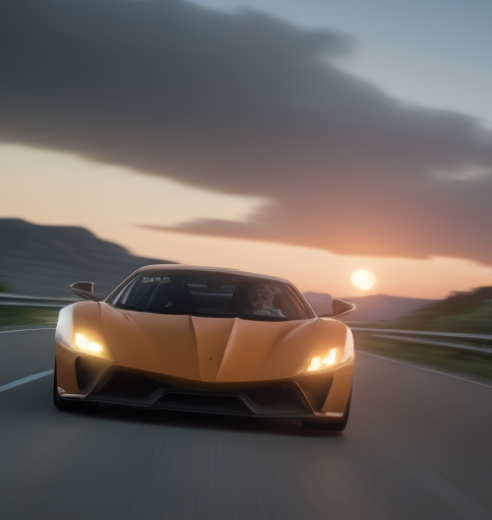

In [77]:
# Load image of a supercar
car_path = "https://github.com/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter09/images/car.png?raw=true"
image = Image.open(urlopen(car_path)).convert("RGB")
image

In [49]:
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [50]:
for key, value in inputs.items():
    print(f"{key}: {value.dtype if isinstance(value, torch.Tensor) else type(value)}")

pixel_values: torch.float16


In [51]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50265: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [52]:
text_ids = blip_processor.tokenizer("Her vocalization was remarkably melodic", return_tensors="pt")
tokens = blip_processor.tokenizer.convert_ids_to_tokens(text_ids["input_ids"][0])
print(tokens)


['</s>', 'Her', 'Ġvocal', 'ization', 'Ġwas', 'Ġremarkably', 'Ġmel', 'odic']


In [53]:
# Preprocess the text
text = "Her vocalization was remarkably melodic"
token_ids = blip_processor(image, text=text, return_tensors="pt")
token_ids = token_ids.to(device, torch.float16)["input_ids"][0]
# Convert input ids back to tokens
tokens =blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 'Ġvocal',
 'ization',
 'Ġwas',
 'Ġremarkably',
 'Ġmel',
 'odic']

In [54]:
tokens = [token.replace("Ġ", "_") for token in tokens]
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 '_vocal',
 'ization',
 '_was',
 '_remarkably',
 '_mel',
 'odic']

In [56]:
for key, value in inputs.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.dtype}")



pixel_values: torch.float16


In [48]:
model = model.to(torch.float16)


## Image captioning

In [55]:
# Generate image ids to be passed to the decoder (LLM)
generated_ids = model.generate(**inputs, max_new_tokens=20)
# Generate text from the image ids
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

'an orange supercar driving on the road at sunset'

In [57]:
generated_ids

tensor([[50265, 50265, 50265, 50265, 50265, 50265, 50265, 50265, 50265, 50265,
         50265, 50265, 50265, 50265, 50265, 50265, 50265, 50265, 50265, 50265,
         50265, 50265, 50265, 50265, 50265, 50265, 50265, 50265, 50265, 50265,
         50265, 50265,     2,   260,  8978,  2422,  5901,  1428,    15,     5,
           921,    23, 18820, 50118]], device='cuda:0')

In [61]:
# Load Rorschach image
url ="https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")

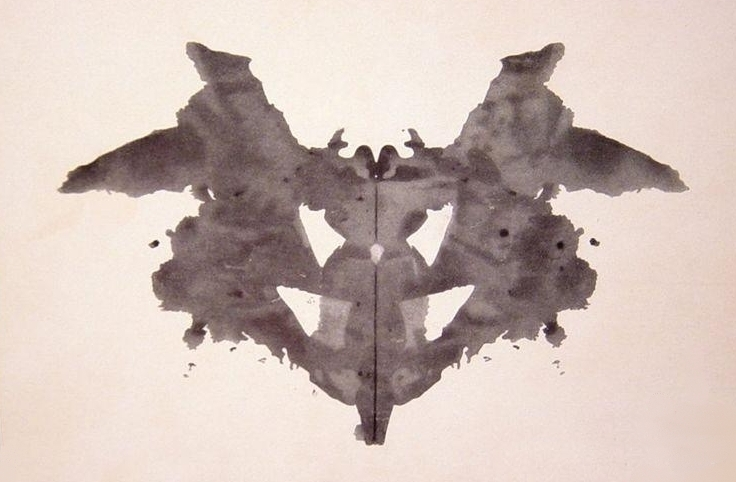

In [62]:
image

In [63]:
inputs2 = blip_processor(image, return_tensors="pt").to(device, torch.float16)
# Generate image ids to be passed to the decoder (LLM)
generated_ids = model.generate(**inputs2, max_new_tokens=20)
# Generate text from the image ids
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

'a black and white ink drawing of a bat'

# Multimodal Chat-Based Prompting

In [64]:
prompt = "Question: Write down what you see in this picture. Answer:"

In [65]:
inputs2 = blip_processor(image,text=prompt ,return_tensors="pt").to(device, torch.float16)
# Generate image ids to be passed to the decoder (LLM)
generated_ids = model.generate(**inputs2, max_new_tokens=20)
# Generate text from the image ids
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

'Question: Write down what you see in this picture. Answer: The image is a black and white ink blot'

In [66]:
# Chat-like prompting
prompt = "Question: Write down what you see in this picture. Answer: The image is a black and white ink blot. Question: What animal may it looks like ? Answer:"

In [68]:
inputs2 = blip_processor(image,text=prompt ,return_tensors="pt").to(device, torch.float16)
# Generate image ids to be passed to the decoder (LLM)
generated_ids = model.generate(**inputs2, max_new_tokens=20)
# Generate text from the image ids
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

'Question: Write down what you see in this picture. Answer: The image is a black and white ink blot. Question: What animal may it looks like ? Answer: A dog.'

In [83]:
from IPython.display import HTML, display
import ipywidgets as widgets
import torch

def text_eventhandler(*args):
    question = args[0]["new"]
    if question:
        args[0]["owner"].value = ""

        # Create prompt based on memory
        if not memory:
            prompt = " Question: " + question + " Answer:"
        else:
            template = "Question: {} Answer: {}."
            prompt = " ".join(
                [template.format(memory[i][0], memory[i][1]) for i in range(len(memory))]
            ) + " Question: " + question + " Answer:"

        # Generate text safely
        with torch.no_grad():
            inputs = blip_processor(image, text=prompt, return_tensors="pt")

            # Ensure correct data types
            inputs = {
                k: v.to(device, torch.float16) if v.dtype == torch.float32 else v.to(device, torch.int64)
                for k, v in inputs.items()
            }

            # Generate response
            generated_ids = model.generate(**inputs, max_new_tokens=100)
            generated_text = blip_processor.batch_decode(
                generated_ids, skip_special_tokens=True
            )[0].strip().split("Question")[-1]  # Get last response

        # Update memory and display output
        memory.append((question, generated_text))
        output.append_display_data(HTML(f"<b>USER:</b> {question}"))
        output.append_display_data(HTML(f"<b>BLIP-2:</b> {generated_text}"))
        output.append_display_data(HTML("<br>"))

# Prepare widgets
in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()
memory = []

# Display chat box
display(widgets.VBox(
    children=[output, in_text],
    layout=widgets.Layout(display="inline-flex", flex_flow="column-reverse")
))


In [ ]:
Write down what you see in this picture